# Comparison of the methods and conclusions

In this last notebook I am going to compare the best model obtained for each of the methods tried in the project. In order to carry out an unbiased comparison I will compute the evaluation metrics using the validation set, a set of data which has never been used during the previous phases of this work.

## Application of the best models to the validation set

In [4]:
import my_utils as u
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [136]:
class_label = u.get_class_labels()

In [7]:
#SVM
#importing the validation set
x_val, y_val, df_data = u.get_images(u.val_files)
#reshape the matrices in one dimensional vectors
x_val_flat = np.reshape(x_val, newshape=(x_val.shape[0], -1))
#rescaling the integers to float in the range [0,1]
x_val_flat = x_val_flat/256
x_val = x_val/256

100%|████████████████████████████████████████| 4800/4800 [00:05<00:00, 887.28it/s]


In [6]:
%%time
results_df = pd.DataFrame()

#opening best SVM classifier
with open('polysvc_5.model', 'rb') as f:
        classifier = pickle.load(f)
        new_entry = {'method': 'SVM', 'classifier': classifier, 'y_pred': classifier.predict(x_val_flat)}
        results_df = results_df.append(new_entry, ignore_index=True)

CPU times: user 9min 23s, sys: 2.61 s, total: 9min 26s
Wall time: 9min 42s


In [92]:
%%time
#opening best FNNN classifier
import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout
from tensorflow import keras
import os

#transforming inputs of the validation set
#according to the pca fit of the trained ffnn
from sklearn.decomposition import PCA
with open(f"pca.db", 'rb') as fmod:
        pca = pickle.load(fmod)
x_val_red = pca.transform(x_val_flat)

ffnn_mod = keras.models.load_model("ffnn5.Adam.relu.1.2")
new_entry = {'method': 'FFNN', 'classifier': ffnn_mod, 'y_pred': ffnn_mod.predict(x_val_red).argmax(axis=1)}
results_df = results_df.append(new_entry, ignore_index=True)

CPU times: user 5.91 s, sys: 1.53 s, total: 7.44 s
Wall time: 4.68 s


In [93]:
%%time
#opening best CNN classifier
cnn_mod = keras.models.load_model("singleConvDroputCNN.CNN")
new_entry = {'method': 'CNN', 'classifier': cnn_mod, 'y_pred': cnn_mod.predict(x_val).argmax(axis=1)}
results_df = results_df.append(new_entry, ignore_index=True)

2022-02-03 18:41:49.200800: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 245376000 exceeds 10% of free system memory.


CPU times: user 8.1 s, sys: 452 ms, total: 8.55 s
Wall time: 3.37 s


In [12]:
results_df

,classifier,method,y_pred
0,"SVC(C=5, kernel='poly')",SVM,"[21, 21, 15, 0, 21, 1, 21, 15, 15, 17, 17, 1, ..."
1,<tensorflow.python.keras.engine.sequential.Seq...,FFNN,"[0, 5, 15, 5, 21, 1, 0, 15, 15, 17, 17, 0, 0, ..."
2,<tensorflow.python.keras.engine.functional.Fun...,CNN,"[0, 0, 15, 13, 0, 0, 0, 15, 15, 17, 6, 0, 0, 1..."


## Confusion matrices

Here I computed the confusion matrices of all of the best models compared in this notebook.

In [14]:
from sklearn.metrics import confusion_matrix

#computing confusion matrix for each model
results_df['cmatrix'] = results_df['y_pred'].progress_apply(lambda y_pred: confusion_matrix(y_val, y_pred))

#computing, for each model, the confusion matrix 
#with each element normalized with the number of elements 
#belonging to the same true class
results_df['cmatrix_truen'] = results_df['y_pred'].progress_apply(lambda y_pred: confusion_matrix(y_val, y_pred, normalize='true'))

100%|██████████████████████████████████████████████| 3/3 [00:00<00:00, 246.81it/s]


In [151]:
#plotting confusion matrices
from matplotlib import pyplot as plt
import seaborn as sn

def plot_conf(i):
    plt.figure(figsize = (13,10))
    cmat = results_df.iloc[i]['cmatrix_truen']*100
    sn.heatmap(cmat, annot=True, fmt='.1f')

    plt.title(results_df.iloc[i]['method'], fontsize=15)
    plt.xlabel('Predicted class')
    plt.ylabel('Actual class')
    fig = plt.gcf()
    #generate class legend

    fig.text(0.9, 0.82, "Class labels and frequency\n in the validation set", fontsize=15)
    class_labels = u.get_class_labels()
    class_labels['val_perc'] = class_labels['n_val']*100/class_labels['n_val'].sum()
    classes=""
    perc=""
    for i, row in class_labels.iterrows():
        classes = classes + f"{row['class_id']:>2}:  {row['class'].replace('_', ' '):<25}\n"
        perc = perc + f"{row['val_perc']:>5.2f}%\n"

    fig.text(0.9, 0.42, classes, fontsize=11)
    fig.text(1.1, 0.42, perc, fontsize=11) 
    

The images below show the confusion matrices where, in each cell the respective value is shown (expressed as a percentage with the % symbol omitted).

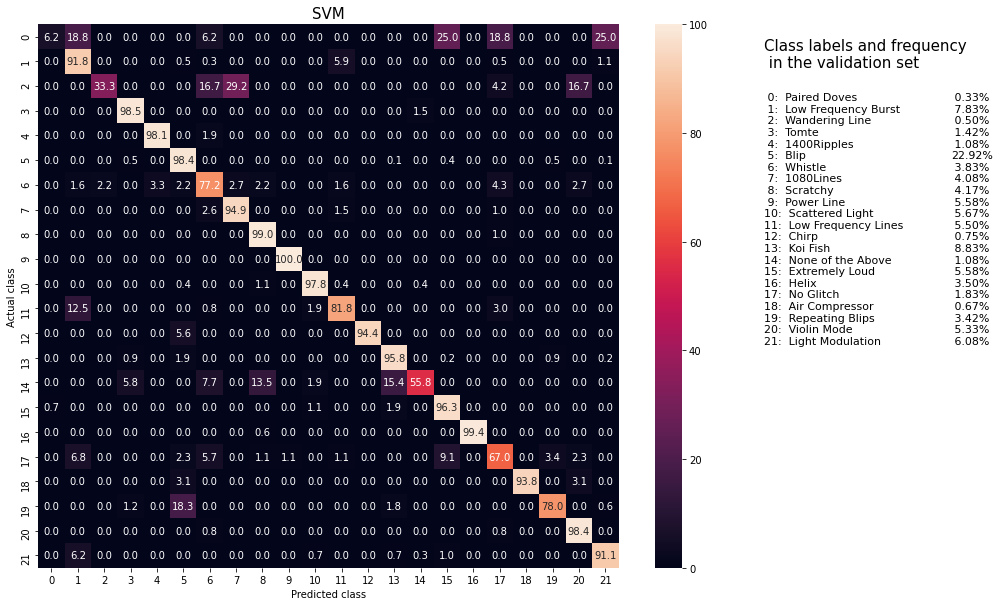

In [152]:
plot_conf(0)

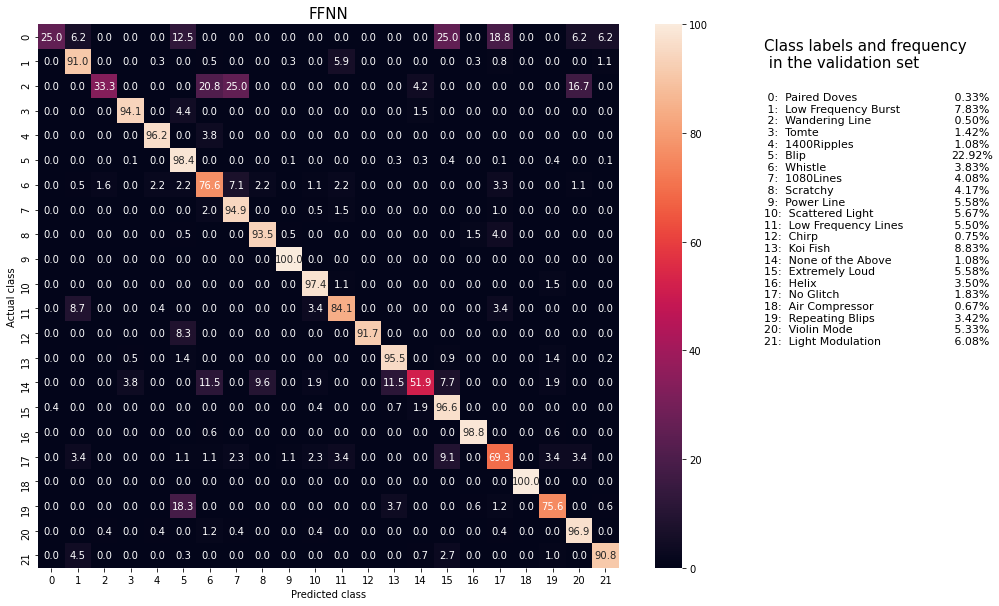

In [153]:
plot_conf(1)

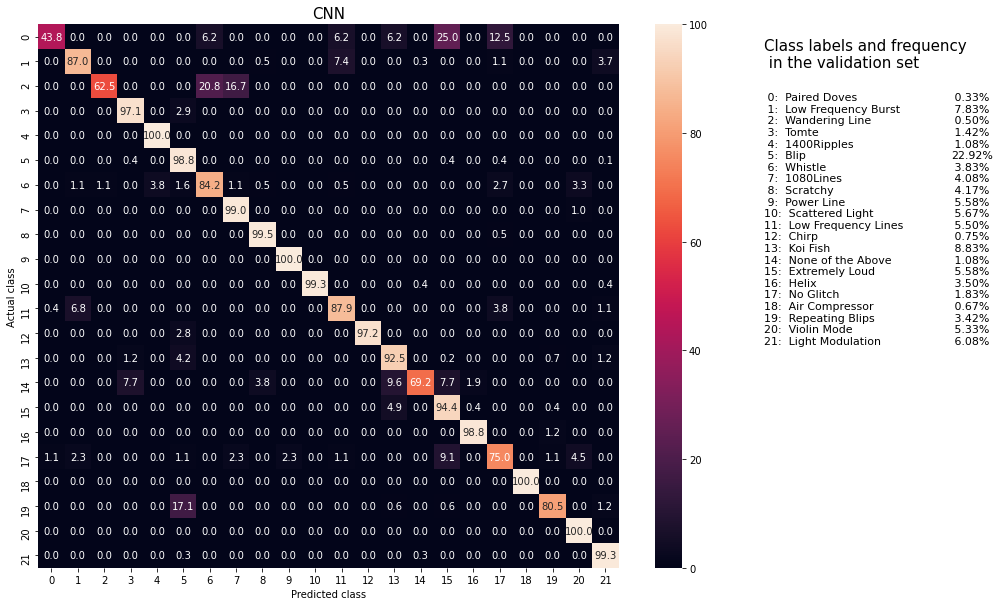

In [154]:
plot_conf(2)

They all present similar features. There are some classes with a diagonal value of 100% which are thus predicted perfectly and most of the classes present recall values above 90%.

There are however also some non null off-diagonal elements indicating where and how these models fail. These results show that all of the models fail in very similar ways.
In the next section I will discuss these problems.

## Main failure points

From the plots of the confusion matrices above it is possible to see that all of the three models fail predicting some of the elements of the following classes:

    - Paired Doves
    - Wandering Line
    - Low frequency Lines
    - None of the above
    - Repeating blips
    
Lets analyze separately each of these classes plotting some of the correctly classified images and some of the ones that were not correctly labeled. These are the results of the convolutional neural network which is the method that provided the best classification.

### Paired Doves

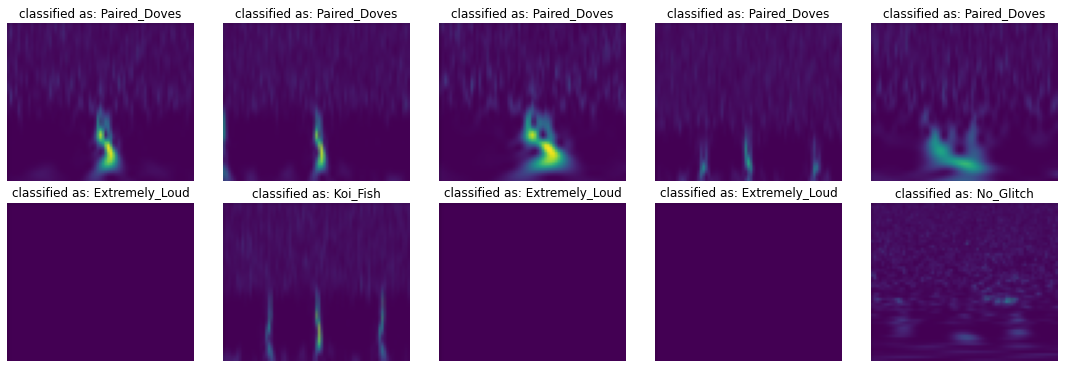

In [146]:
def plot_pred(clas):
    y_pred = results_df[results_df.method=='CNN'].y_pred.iloc[0]
    indexes = np.where(y_val==clas)[0]
    correct = [i for i in indexes if y_pred[i]==clas]
    incorrect = [i for i in indexes if y_pred[i]!=clas]
    c_i = [correct, incorrect]

    fig, axs = plt.subplots(2,5, figsize=(15,5), constrained_layout=True)
    axs = axs.flatten()
    for i in range(0,10):
        axs[i].imshow(x_val[c_i[int(i/5)][i%5]])
        axs[i].set_axis_off()
        axs[i].set_title(f"classified as: {class_label.iloc[y_pred[c_i[int(i/5)][i%5]]]['class']}")
plot_pred(0)

### Wandering Line

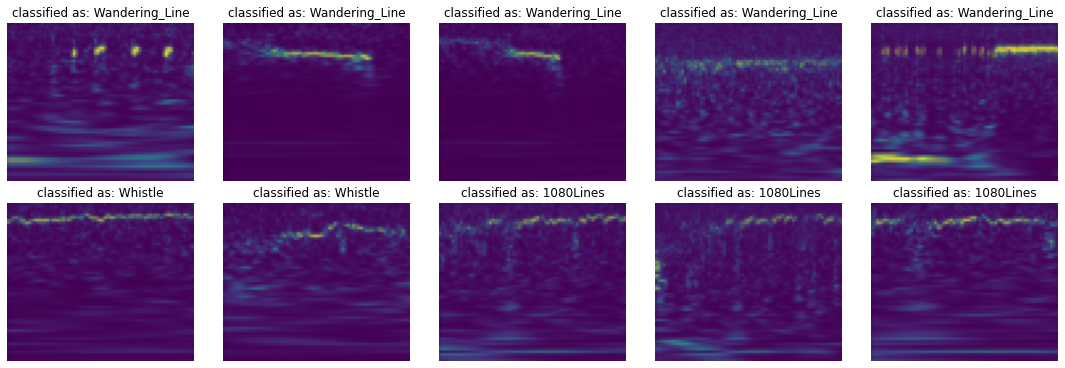

In [147]:
plot_pred(2)

### Low Frequency Lines

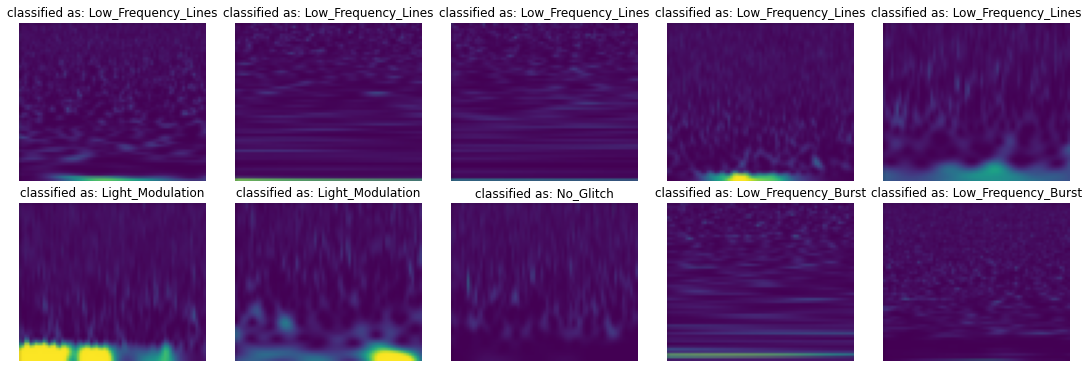

In [148]:
plot_pred(11)

### None of the above

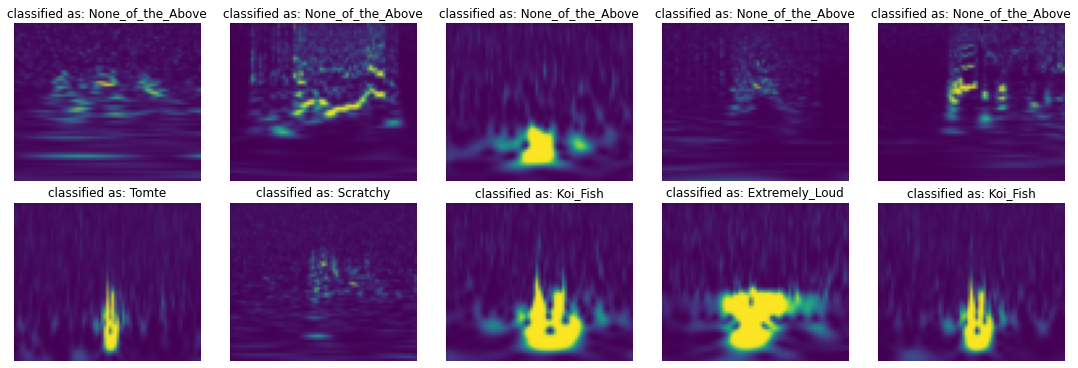

In [149]:
plot_pred(14)

### Repeating Blips

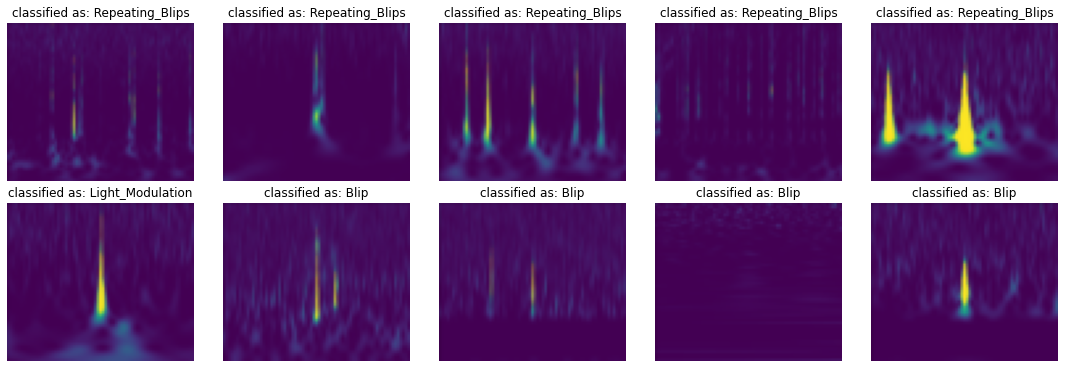

In [150]:
plot_pred(19)

All this examples are errors of the convolutional neural network.
From the previous images, comparing the misclassified images with examples (see notebook 1) of the class in which they were misplaced, the difficulties of the convolutional network become clear.
Most of the misclassified images would probably have been incorrectly labeled also by humans. 
Some images, for example, do not show any identifiable pattern.
Further investigation is needed to understand if these images were actually incorrectly misclassified during the development of the dataset or, if they are somewhat correlated with other images that caused their placement in the same class.

## Metrics

In order to complete the comparison I also computed the same metrics used in the entire project.

In [78]:
#computing metrics

#Accuracy and  balanced accuracy
def compute_balacc(cmat):
    bacc = 0
    for i, row in enumerate(cmat):
        bacc += row[i]/row.sum()
    return bacc/len(cmat)
results_df['accuracy'] = results_df['cmatrix'].progress_apply(lambda cmat: cmat.trace()/cmat.sum())
results_df['balanced_accuracy'] = results_df['cmatrix'].progress_apply(lambda cmat: compute_balacc(cmat))

#F1-score and MCC
#F1 score
def compute_macroF1(cmat):
    mprec = 0
    mrec = 0
    #compute macro precision and macro recall
    for i in range(0, len(cmat)):
        mprec += (cmat[i][i]/(cmat[:,i].sum()+1e-20))
        mrec  += (cmat[i][i]/(cmat[i].sum()+1e-20))
   
    mprec /= len(cmat)
    mrec  /= len(cmat)

    return 2*(mprec*mrec)/(mprec+mrec)

def compute_MCC(cmat):
    c = cmat.trace()
    s = cmat.sum()
    p = [cmat[:,k].sum()+1e-20 for k in range(0, len(cmat))]
    t = [cmat[k].sum() for k in range(0, len(cmat))]

    mcc = (c*s - np.dot(p,t))/np.sqrt((s**2-np.dot(p,p))*(s**2-np.dot(t,t)))
    return mcc

results_df['macroF1'] = results_df['cmatrix'].progress_apply(lambda cmat: compute_macroF1(cmat))
results_df['MCC'] = results_df['cmatrix'].progress_apply(lambda cmat: compute_MCC(cmat))

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 1202.27it/s]


These metrics are shown in the following table

In [91]:
results_df[['method', 'accuracy', 'balanced_accuracy', 'macroF1', 'MCC']].round(4)

,method,accuracy,balanced_accuracy,macroF1,MCC
0,SVM,0.9290,0.8396,0.8592,0.9216
1,FFNN,0.9248,0.8416,0.8643,0.9170
2,CNN,0.9438,0.8936,0.9093,0.9379


The convolutional neural network was the method that scored the highest values for these metrics. In particular, it was able to obtain an about 5% higher balanced accuracy with respect to the other methods showing to be better in correctly classifying less populated classes.

On the other end, the comparison between SVM and FFNN is not so simple. The metrics computed disagree on the best model and all the values are very similar. FFNN obtained greater scores in the balanced accuracy and F1-score metrics. Both these metrics give the same weight to each class resulting in the predictions of the less populated classes having more influence on the final score.
SVM instead obtained a slightly better accuracy and MCC score.
These two methods are thus very similar and an hypothetical choice between them must rely on different factors.

For example, the time needed for the application of the trained models to new data might be relevant.
In the cells above I have used the %time directive of the notebook to measure the time needed for computing the predictions on the validation set, obtaining the following results:

    SVM  : 9 minutes
    FFNN : 6 seconds
    CNN  : 8 seconds
    
These times are just indicatives, especially those of neural networks which are of few seconds, because they rely on different factors, such as the state of the computer while doing the computation, which were not taken into account. However, the order of magnitude of these times should be correct, clearly favoring neural networks over SVM.
It should also be noted that FFNN were used on the dataset reduced using PCA while the SVM was fitted on the whole data. This might influence both the metrics and the times needed for applications to new data.

## Conclusion

In this project I was able to apply different machine learning techniques to the gravity spy dataset.
For each of them I tried using some different values for the main hyperparameters. However, many elements of these models were kept at their default value and some choices were made following literature's suggestions without deeper analysis (such as the choice of the optimizer). The results were satisfying and thus did not urge a further discussion of these elements.

The best model obtained, for the solution of the classification problem addressed, is a custom convolutional neural network with three blocks, made of a convolutional layer and a max pooling layer, followed by a dropout layer and a dense network of three layers including the output one.

With this model I obtained the following scores:
    
    Accuracy         : 94.38%
    Balanced accuracy: 89.36%
    F1-score         : 90.93%
    MCC              : 93.79%
    
These scores are significantly lower than the ones obtained by previous works in literature. For example,  Zevin et al. (2017) obtained an accuracy of 97.1% using a convolutional neural network, Bahaadini et al. reached an accuracy of 98.21% using  an ensemble of deep neural network models and an SVM model.
Note however that these results were obtained on a version of the original dataset while in this project all the images were rescaled by approximately a factor of 1/8. The lower accuracy obtained may thus be explained by this reduction of the original data.

The aims of this project were the comparison of the different models and the realization of a proof of concept which could show the potentiality of the gravity spy dataset even with a heavy resizement of the images which could be useful in applications characterized by low computational resources.
I believe that these objectives have been successfully pursued.

## References

Bahaadini, Sara, et al. "Machine learning for Gravity Spy: Glitch classification and dataset." Information Sciences 444 (2018): 172-186.

Zevin, Michael, et al. _Gravity Spy: integrating advanced LIGO detector characterization, machine learning, and citizen science._ Classical and quantum gravity 34.6 (2017): 064003.